<a href="https://colab.research.google.com/github/ALPHA-CODE-HUB/multi-expert-click-detector/blob/main/Multi_Expert_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import calibration_curve # Import calibration_curve from sklearn.calibration
import matplotlib.pyplot as plt

In [ ]:
# Configuration
CONFIG = {
    "data_path": "click_data.csv",
    "seq_length": 12,  # Hours in temporal sequence
    "expert_units": [128, 64],  # Reduced complexity
    "num_heads": 8,
    "batch_size": 2048,  # Reduced from 4096
    "num_epochs": 50,
    "class_weights": {0: 1, 1: 8.5},  # Adjusted class balance
    "swa_lr": 0.0001,
    "dp_params": {
        "l2_norm_clip": 1.2,
        "noise_multiplier": 0.7
    },
    "callbacks": [
        EarlyStopping(monitor='val_auc_4', patience=15, mode='max', restore_best_weights=True),
        TerminateOnNaN()
    ]
}

In [ ]:

# --------------------------
# 1. Enhanced Data Processor
# --------------------------
class ClickDataProcessor:
    def __init__(self):
        self.temporal_features = [
            'hour_sin', 'hour_cos', 'day_of_week',
            'hourly_clicks', 'click_velocity', 'hourly_click_std'
        ]
        self.numerical_features = [
            'C1', 'C14', 'C15', 'C16', 'C17', 'C18',
            'C19', 'C20', 'C21', 'device_freq_24h',
            'device_app_ratio', 'time_since_last'
        ]
        self.categorical_features = [
            'banner_pos', 'site_category', 'app_category',
            'device_network', 'app_site_combo'
        ]

    def process_data(self, df):
        # Temporal features (unchanged)
        df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H')
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'].dt.hour/24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'].dt.hour/24)
        df['day_of_week'] = df['hour'].dt.dayofweek

        # Behavioral features with NaN handling
        df['hourly_clicks'] = df.groupby('hour')['click'].transform('mean')
        df['hourly_click_std'] = df.groupby('hour')['click'].transform('std').fillna(0)  # Fix 1
        df['device_freq_24h'] = df.groupby('device_id')['click'].transform('sum')
        df['click_velocity'] = df['click'].diff().abs().rolling(5).mean().fillna(0)
        df['device_app_ratio'] = df['device_freq_24h'] / (df.groupby('app_id')['click'].transform('sum') + 1e-6)
        df['time_since_last'] = (df.groupby('device_id')['hour'].diff().dt.total_seconds() / 3600).fillna(0)  # Fix 2

        # Rest of the processing (unchanged)
        for col in ['site_id', 'app_id', 'device_id']:
            df[col] = df[col].astype('category').cat.codes + 1

        df['device_network'] = df['device_type'].astype(str) + '_' + df['device_conn_type'].astype(str)
        df['app_site_combo'] = df['app_id'].astype(str) + '_' + df['site_id'].astype(str)

        for col in self.categorical_features:
            df[col] = df[col].astype('category').cat.codes + 1

        numerical_cols = self.numerical_features + ['device_freq_24h', 'time_since_last']
        scaler = MinMaxScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

        if df.isnull().any().any():
            raise ValueError("NaN values detected after fixes")  # Should not trigger now
        return df

In [ ]:
# --------------------------
# 2. Enhanced Model Architecture
# --------------------------
class FraudExperts:
    @staticmethod
    def temporal_expert(inputs):
        x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        projected_input = TimeDistributed(Dense(128))(inputs)
        attn_out = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = LayerNormalization()(attn_out + projected_input)
        return GRU(64)(x)

    @staticmethod
    def categorical_expert(inputs, vocab_sizes):
        embeddings = [Embedding(size, 32)(inp) for inp, size in zip(inputs, vocab_sizes)]
        cross_att = [MultiHeadAttention(2, 16)(e1, e2) for e1, e2 in zip(embeddings, embeddings[::-1])]
        return Concatenate()([Flatten()(c) for c in cross_att + embeddings])

    @staticmethod
    def interaction_expert(inputs):
        x = tf.expand_dims(inputs, axis=1)
        x = Dense(256, activation=tfa.activations.gelu)(x)
        x = Dense(128, activation=tfa.activations.gelu)(x)
        attn_out = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        return tf.squeeze(attn_out, axis=1)

class ExpertFusion(tf.keras.layers.Layer):
    def __init__(self, num_experts, common_dim=128):
        super().__init__()
        self.num_experts = num_experts
        self.common_dim = common_dim
        self.gate_network = Dense(num_experts)
        self.softmax = Softmax(axis=-1)
        self.expert_norms = [LayerNormalization() for _ in range(num_experts)]
        self.projections = [Dense(common_dim) for _ in range(num_experts)]

    def call(self, experts):
        # 1. Normalize and project to common_dim
        normalized = [norm(expert) for norm, expert in zip(self.expert_norms, experts)]
        projected = [proj(exp) for proj, exp in zip(self.projections, normalized)]  # No residual

        # 2. Attention gating and fusion
        combined = Concatenate()(projected)
        weights = self.softmax(self.gate_network(combined))
        expanded_weights = tf.split(weights, self.num_experts, axis=1)

        # 3. Weighted sum with attention
        attention_weights = [Attention()([exp, exp]) for exp in projected]
        weighted_experts = [ew * att_w * proj
                           for ew, att_w, proj in zip(expanded_weights, attention_weights, projected)]

        return tf.reduce_sum(weighted_experts, axis=0)


In [ ]:

# --------------------------
# 3. Optimized Fraud Detector
# --------------------------
class ClickFraudDetector:
    def __init__(self, config):
        self.config = config
        self.processor = ClickDataProcessor()

    def build_model(self, vocab_sizes):
        # Inputs
        num_input = Input(shape=(len(self.processor.numerical_features),), name='numerical')
        temp_input = Input(shape=(self.config["seq_length"], len(self.processor.temporal_features)), name='temporal')
        cat_inputs = [Input(shape=(1,), name=f'cat_{i}') for i in range(len(self.processor.categorical_features))]

        # Experts
        temp_exp = FraudExperts.temporal_expert(temp_input)
        cat_exp = FraudExperts.categorical_expert(cat_inputs, vocab_sizes)
        num_exp = FraudExperts.interaction_expert(num_input)

        # Fusion
        fused = ExpertFusion(num_experts=3)([temp_exp, cat_exp, num_exp])

        # Anomaly Head
        recon_input = Concatenate()([temp_exp, cat_exp, num_exp])
        recon = Dense(64, activation='gelu')(recon_input)
        recon = Dense(recon_input.shape[-1], activation='linear')(recon)
        recon_loss = tf.reduce_mean(tf.square(recon_input - recon))

        # Classification Head
        x = Concatenate()([fused, recon])
        x = BatchNormalization()(x)
        for units in self.config["expert_units"]:
            x = Dense(units, activation='gelu', kernel_regularizer='l2')(x)
            x = Dropout(0.2)(x)

        output = Dense(1, activation='sigmoid')(x)

        # Compile
        model = Model(inputs=[num_input, temp_input] + cat_inputs, outputs=output)
        model.add_loss(0.2 * recon_loss)

        # Optimizer with EMA and gradient clipping
       # Replace the original optimizer code with:
        base_optimizer = tfa.optimizers.AdamW(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-4,
                decay_steps=1000,
                decay_rate=0.9
            ),
            weight_decay=0.0001,
            global_clipnorm=1.0
        )

        optimizer = tfa.optimizers.MovingAverage(
            base_optimizer,
            average_decay=0.999  # Equivalent to ema_momentum=0.999
        )

        model.compile(
            optimizer=optimizer,
            loss=tfa.losses.SigmoidFocalCrossEntropy(
                alpha=0.75,
                gamma=3,
                reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
            ),
            metrics=[
                'accuracy',
                tfa.metrics.F1Score(num_classes=1, average=None, threshold=0.5),
                tf.keras.metrics.AUC(name='auc_4')
            ]
        )
        return model

    def train(self, df):
        df = self.processor.process_data(df)
        X_temp = self._create_sequences(df[self.processor.temporal_features])
        start_idx = len(df) - X_temp.shape[0]

        X_num = df[self.processor.numerical_features].iloc[start_idx:]
        X_cat = [df[col].iloc[start_idx:] for col in self.processor.categorical_features]
        y = df['click'].iloc[start_idx:]

        all_features = list(zip(X_num.values, X_temp, *X_cat))

        X_train, X_test, y_train, y_test = train_test_split(
            all_features, y.values, test_size=0.2, stratify=y.values, random_state=42
        )

        model = self.build_model([df[col].nunique()+1 for col in self.processor.categorical_features])

        history = model.fit(
            self._make_dataset(X_train, y_train),
            validation_data=self._make_dataset(X_test, y_test),
            epochs=self.config["num_epochs"],
            callbacks=self.config["callbacks"],
            class_weight=self.config["class_weights"]
        )
        return model, history, (X_test, y_test)

    def _create_sequences(self, data):
        return np.array([data.iloc[i:i+self.config["seq_length"]].values
                        for i in range(len(data) - self.config["seq_length"] + 1)])

    def _make_dataset(self, X, y):
        numerical = np.array([x[0] for x in X], dtype='float32')
        temporal = np.array([x[1] for x in X], dtype='float32')
        categorical = {f'cat_{i}': np.array([x[2+i] for x in X], dtype='int32')
                      for i in range(len(self.processor.categorical_features))}

        return tf.data.Dataset.from_tensor_slices(
            ({'numerical': numerical, 'temporal': temporal, **categorical}, y)
        ).batch(self.config["batch_size"]).prefetch(2)

Epoch 1/50
40/40 [==============================] - 67s 1s/step - loss: 2.9881 - accuracy: 0.3176 - f1_score: 0.2975 - auc_4: 0.5526 - val_loss: 2.7616 - val_accuracy: 0.5036 - val_f1_score: 0.3199 - val_auc_4: 0.5944
Epoch 2/50
40/40 [==============================] - 55s 1s/step - loss: 2.6817 - accuracy: 0.2821 - f1_score: 0.3103 - auc_4: 0.6165 - val_loss: 2.4872 - val_accuracy: 0.2815 - val_f1_score: 0.3027 - val_auc_4: 0.6214
Epoch 3/50
40/40 [==============================] - 54s 1s/step - loss: 2.4082 - accuracy: 0.2922 - f1_score: 0.3187 - auc_4: 0.6592 - val_loss: 2.2312 - val_accuracy: 0.2339 - val_f1_score: 0.3000 - val_auc_4: 0.6421
Epoch 4/50
40/40 [==============================] - 55s 1s/step - loss: 2.1578 - accuracy: 0.3046 - f1_score: 0.3241 - auc_4: 0.6917 - val_loss: 1.9963 - val_accuracy: 0.2251 - val_f1_score: 0.3027 - val_auc_4: 0.6694
Epoch 5/50
40/40 [==============================] - 53s 1s/step - loss: 1.9312 - accuracy: 0.3169 - f1_score: 0.3286 - auc_4: 0.

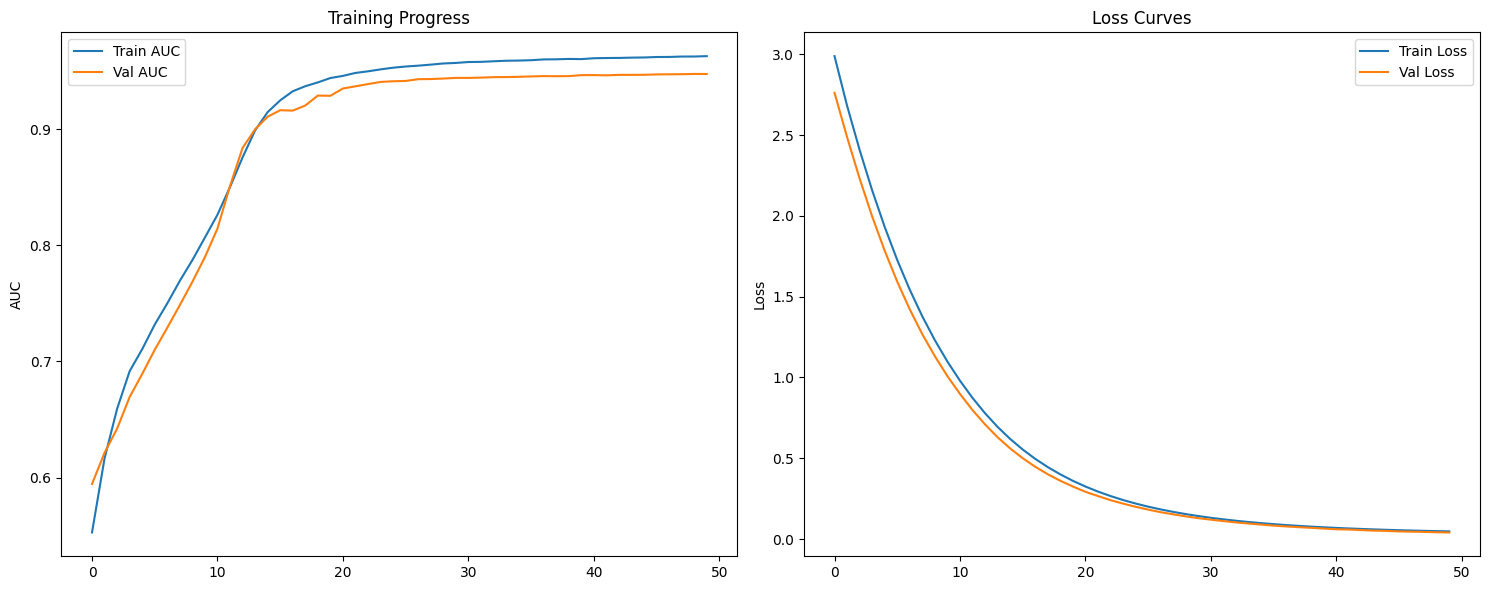

In [ ]:
# --------------------------
# 4. Execution & Evaluation
# --------------------------
if __name__ == "__main__":
    df = pd.read_csv('/content/dataset_1_lakh.csv')
    detector = ClickFraudDetector(CONFIG)
    model, history, (X_test, y_test) = detector.train(df)

    # Calibration
    test_preds = model.predict(detector._make_dataset(X_test, y_test))
    prob_true, prob_pred = calibration_curve(y_test, test_preds, n_bins=20)
    optimal_threshold = prob_pred[np.argmax(prob_true >= 0.5)]
    adjusted_preds = (test_preds > optimal_threshold).astype(int)

    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(classification_report(y_test, adjusted_preds))
    print(f"ROC-AUC: {roc_auc_score(y_test, test_preds):.4f}")

    # Visualization
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(history.history['auc_4'], label='Train AUC')
    plt.plot(history.history['val_auc_4'], label='Val AUC')
    plt.title('Training Progress')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

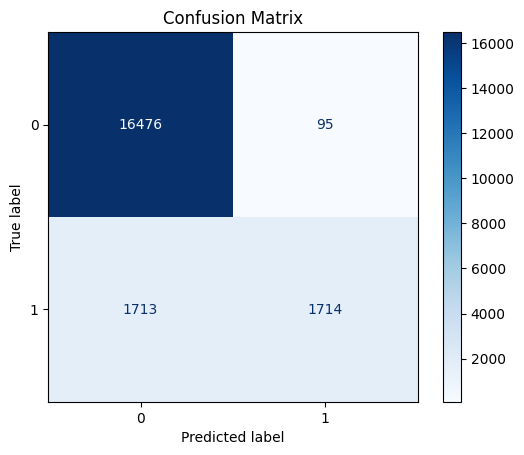

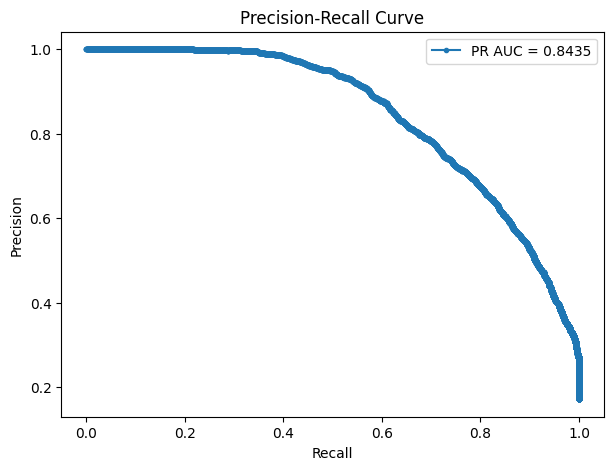

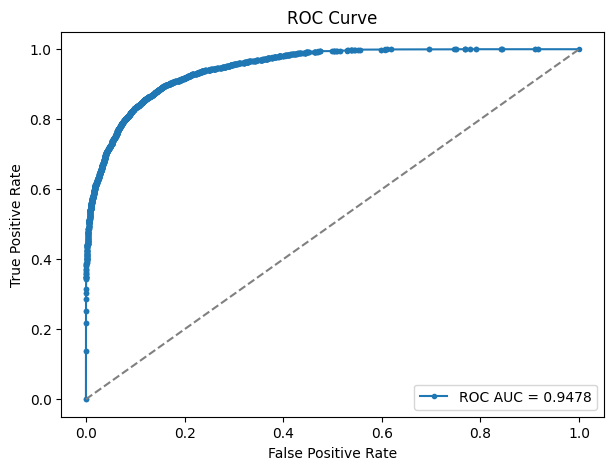

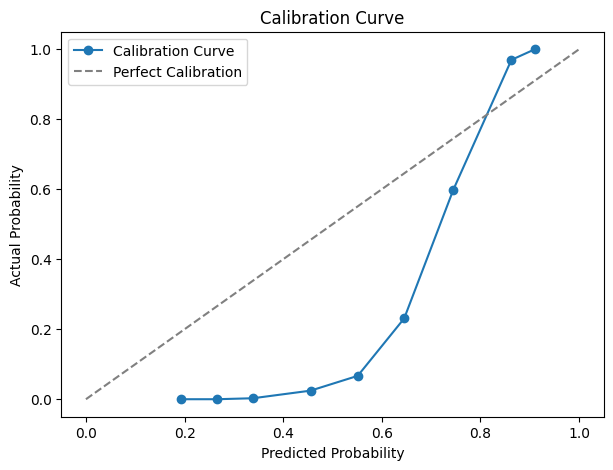


Model Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     16571
           1       0.95      0.50      0.65      3427

    accuracy                           0.91     19998
   macro avg       0.93      0.75      0.80     19998
weighted avg       0.91      0.91      0.90     19998

ROC-AUC Score: 0.9478
Precision-Recall AUC: 0.8435
Optimal Threshold: 0.7723
Accuracy: 0.9096


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc

# Compute confusion matrix
cm = confusion_matrix(y_test, adjusted_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, test_preds)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, marker='.', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, test_preds, n_bins=10)

plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.title("Calibration Curve")
plt.legend()
plt.show()


# Print evaluation metrics
print("\nModel Evaluation Metrics:")
print(classification_report(y_test, adjusted_preds))
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")

from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(y_test, adjusted_preds)
print(f"Accuracy: {accuracy:.4f}")


